In [5]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# Wczytywanie danych

In [ ]:
data=pd.read_csv(r'list_v7_final.csv')
data.drop_duplicates(subset=['Game_name'],inplace=True)
data.dropna(axis=0,inplace=True)
data.reset_index(drop=True, inplace=True)
data.info()

# Czyszczenie danych

In [7]:
stop_words = set(pd.read_csv(r'polish_stopwords.txt')['a']) 

def text_cleaner(text,num):

    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)  
    newString = re.sub(r"'s\b",'',newString)
    newString = re.sub("[^AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpQqRrSsŚśTtUuWwVvXxYyZzŹźŻż]", " ", newString) 

    if(num==0):
        tokens = [w for w in newString.split() if w not in stop_words]
    else:
        tokens=newString.split()

    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [8]:
cleaned_text = []
cleaned_summary = []

for i in range(len(data)):
    cleaned_text.append(text_cleaner(data['Opis'][i],0)) 
    cleaned_summary.append(text_cleaner(data['Short_text'][i],1))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

# Ocena długości tekstów, celem eliminacji nielicznych długich
Pozwala to na ograniczenie rozmiaru modelu

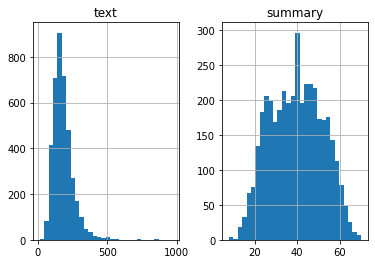

In [9]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Wyliczanie wskaźnika pokrycia zboioru danych dla zadanej długości maksymalnej, oraz ograniczenie jego wielkości na tej podstawie:

In [ ]:
max_text_len=300

cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=max_text_len):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

In [ ]:
max_summary_len=60

cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=max_summary_len):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

In [12]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

# Tokenizacja wyrazów z tekstów z bazy danych

In [13]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt += 1
    tot_freq += value
    if(value<thresh):
        cnt += 1
        freq += value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [ ]:
import pickle
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

x_voc

In [16]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt += 1
    tot_freq += value
    if(value<thresh):
        cnt += 1
        freq += value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [ ]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)   

In [19]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [20]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim = 200

encoder_inputs = Input(shape=(max_text_len,))

enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

encoder_lstm4=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3)

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs1,decoder_fwd_state1, decoder_back_state1 = decoder_lstm1(dec_emb,initial_state=[state_h, state_c])

decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state2, decoder_back_state2 = decoder_lstm2(decoder_outputs1)

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=25,callbacks=[es],batch_size=200, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.grid()
pyplot.show()

In [22]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [23]:
np.save('reverse_target_word_index.npy', reverse_target_word_index) 
np.save('reverse_source_word_index.npy', reverse_source_word_index) 
np.save('target_word_index.npy', target_word_index) 

In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
encoder_model.summary()
#encoder_model.save('/content/drive/MyDrive/models/my_encoder')

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 

d_decoder_outputs1, d_state_h1, d_state_c1 = decoder_lstm1(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
d_decoder_outputs, d_state_h, d_state_c = decoder_lstm2(d_decoder_outputs1)


d_decoder_outputs = decoder_dense(d_decoder_outputs) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [d_decoder_outputs] + [d_state_h, d_state_c])

decoder_model.summary()

#decoder_model.save('/content/drive/MyDrive/models/my_decoder')

In [31]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [32]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")
